# IK with the REEM-C robot

This short tutorial will only show you an IK on a more elaborated robot: [REEM-C](http://reemc.pal-robotics.com/en/) from PAL robotics.

We choosed this robot because the [specifications](https://github.com/pal-robotics/reemc_robot) are freely available.

Also a humanoid robot will allow to show you that the IK we formulate in the [last tutorial](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MyFirstIK.ipynb) will work on a robot with a free floating base. This is possible because the `rbd::Jacobian` class and all previously presented algortihms work with all the joints supported by [RBDyn](https://github.com/jorisv/RBDyn).

The robot specification are given by an [urdf](http://wiki.ros.org/urdf/XML). It's possible to load a `rbd::MultiBodyGraph` directly from that kind of file with the [RBDynUrdf library](https://github.com/jorisv/RBDynUrdf). But to avoid you to compile this library we have serialized the robot thank's to python pickle module.

First let's load and display the robot.

In [1]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

viewer.scene.camera.view_up = (0., 0., 1.)

display_number = 1
def display():
    global display_number
    path = 'img/ReemCIK/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

In [2]:
import numpy as np
import eigen3 as e
import spacevecalg as sva
import rbdyn as rbd

from robots import ReemC

# load the REEM-C robot
mbg, mb, mbc, meshDict = ReemC()

# re create it with a free joint as base
mb = mbg.makeMultiBody(mb.body(0).id(), False)
mbc = rbd.MultiBodyConfig(mb)
mbc.zero(mb)

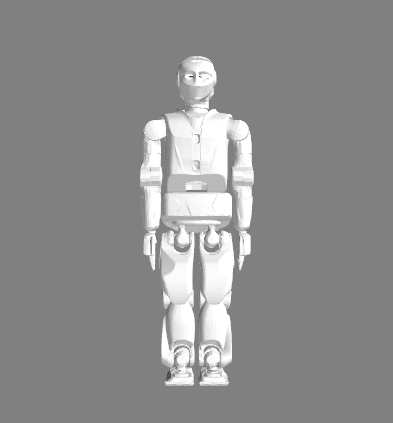

In [3]:
# draw the robot
from graph import MultiBodyViz

mbv = MultiBodyViz(mbg, mb, meshDict=meshDict)
mbv.addActors(viewer.scene)

rbd.forwardKinematics(mb, mbc)
rbd.forwardVelocity(mb, mbc) # for motionSubspace

bodyPosW = list(mbc.bodyPosW)

viewer.scene.camera.focal_point = tuple(bodyPosW[0].translation())
viewer.scene.camera.position = tuple(bodyPosW[0].translation() + e.Vector3d.UnitX()*4)

mbv.display(mb, mbc, displayJoints=False)
display()

## IK

We will use the same multi-task IK solver that we have presented in the [last tutorial](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MyFirstIK.ipynb). We only add the optional possibility to give a weight per task dimension instead of a global weight for the task.

The source of the IK solver can be found [here](https://github.com/jorisv/sva_rbdyn_tutorials/blob/master/ik/multi_task.py).

## Tasks

We provide the already described [Body Task](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MyFirstIK.ipynb#Body-Task) and [Posture Task](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MyFirstIK.ipynb#Posture-Task).
But we have also add the CoM Task that will allow to move the robot center of mass.

All tasks source code can be found [here](https://github.com/jorisv/sva_rbdyn_tutorials/blob/master/ik/ik_tasks.py).

### CoM Task

The error function vector is:
$$
\mathbf{g}^{com} = \mathbf{c}(\mathbf{q}) - \mathbf{c}_T
$$

Where $ \mathbf{c} $ is the robot center of mass and $ \mathbf{c}_T $ the center of mass target.

This task Jacobian is then the CoM jacobian:
$$
J_{\mathbf{g}^{com}} = \frac{\partial \mathbf{g}^{com}}{\partial \mathbf{q}} = J_{CoM}(\mathbf{q})
$$

The code to implement this task is then quite simple:

In [4]:
class CoMTask(object):
    def __init__(self, mb, com_T):
        """
        Target a fixe CoM position.
        Parameters:
          - mb: MultiBody system
          - com_T: Targeted CoM position (eigen3.Vector3d)
        """
        self.com_T = com_T
        self.comJac = rbd.CoMJacobian(mb)

    def g(self, mb, mbc):
        return e.toNumpy(rbd.computeCoM(mb, mbc) - self.com_T)

    def J(self, mb, mbc):
        return e.toNumpy(self.comJac.jacobian(mb, mbc))

## Target

We want to have the robot right foot (right_sole_link) on the ground (initial configuration). Our solver don't support equality constraints, so we will use a Body Task with high gain to achieve a zero motion of this body.

The left foot (left_sole_link) must be a little up and forward, and we don't care about this foot orientation. So we can use a Body Task with low weight on orientation part of the task.

To have a statically stable robot we want the CoM to be over the right foot, here we don't really care of the CoM Z position because it will not change the robot stability. The CoM Task with low weight on the Z axis will allow us to achieve this.

In [5]:
from ik import BodyTask, PostureTask, CoMTask

mbcIK = rbd.MultiBodyConfig(mbc)
bodyPosW = list(mbcIK.bodyPosW)

# create tasks
tasks = []
# don't move the right_sole_link
rSoleId = mbg.bodyIdByName('right_sole_link')
rSoleIndex = mb.bodyIndexById(rSoleId)
X_O_rsole = bodyPosW[rSoleIndex]
rSoleTask = BodyTask(mb, rSoleId, X_O_rsole)
# big weight to be sure the foot doesn't move
tasks.append((100000., rSoleTask))

# set the left_sole_link up
lSoleId = mbg.bodyIdByName('left_sole_link')
lSoleIndex = mb.bodyIndexById(lSoleId)
X_O_lsole = bodyPosW[lSoleIndex]
lSoleTask = BodyTask(mb, lSoleId,
                     sva.PTransformd(X_O_lsole.rotation(),
                                     X_O_lsole.translation() + e.Vector3d(0.15, 0.05, 0.4)))
# low weight for rotational part of this task
tasks.append(((10., 10., 0., 1000., 1000., 1000.), lSoleTask))

# posture task for reedondant joint and numerical stability
postureTask = PostureTask(mb, map(list, mbcIK.q))
tasks.append((10., postureTask))

# CoM over the right_sole_link
com = rbd.computeCoM(mb, mbcIK)
comTask = CoMTask(mb,
                  e.Vector3d(X_O_rsole.translation().x(),
                             X_O_rsole.translation().y(),
                             com.z()))
# We don't really know what is a good target for the Z axis so we set a low weight on it
tasks.append(((1000., 1000., 10.), comTask))

rSoleTask residual: [[ -3.48826591e-09   9.67173833e-10   4.31446192e-09   4.62221064e-09
    2.31870886e-08   9.35323332e-08]]
lSoleTask residual: [[ -4.29403039e-01   3.91866251e-01   5.91384484e-01   3.16337406e-04
    1.34152409e-04  -9.38602427e-04]]
comTask residual: [[-0.00036256 -0.00036602  0.03279093]]


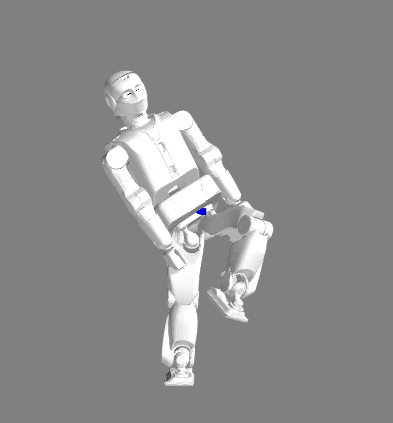

In [6]:
from ik import multi_task_ik

# copy the initial configuration to avoid the algorithm to change it
mbcIKSolve = rbd.MultiBodyConfig(mbcIK)
q_res = None
X_O_p_res = None
alphaInfList = []
for iterate, q, alpha, alphaInf in multi_task_ik(mb, mbcIKSolve, tasks, delta=0.5, maxIter=200, prec=1e-8):
    q_res = q
    alphaInfList.append(alphaInf)

print 'rSoleTask residual:', rSoleTask.g(mb, mbcIKSolve).T
print 'lSoleTask residual:', lSoleTask.g(mb, mbcIKSolve).T
print 'comTask residual:', comTask.g(mb, mbcIKSolve).T

mbv.display(mb, mbcIKSolve, displayJoints=False)
display()

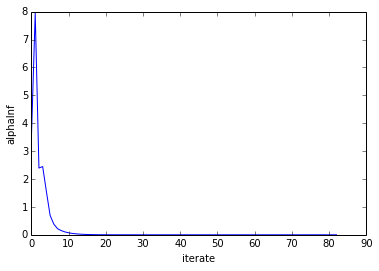

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(alphaInfList)
plt.ylabel('alphaInf')
plt.xlabel('iterate')

## Result

The IK process has succeeded. To converge we have use a lower integration step (0.5 instead of 1). It's because our dummy solver don't use line search or trust region, so using a big integration step at each iteration is likely to not converge.

Also it could be nice in the future to use a real non-linear optimisation solver that manage equality and inequality constraint.

Here the point is not to show a robust IK but how we can easily use [SpaceVecAlg](https://github.com/jorisv/SpaceVecAlg) and [RBDyn](https://github.com/jorisv/RBDyn) to compute task objective and Jacobian.

The robot posture is looking like what we wanted. We can see there a self-collision between the robot right hand and the right leg. To prevent that we can use a collision avoidance task but we will not see it on this tutorial because of the need of a distance query library.

As an exercise you can play with the tasks weights and target to see what will happen (change the CoM task Z target and weight).
You can also add a task on the right hand to prevent the self-collision.